In [ ]:
# import libraries

# keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# basic

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing, model selection and scores

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# nlp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

%matplotlib inline

In [2]:
# read in the data

data = pd.read_csv('../data/cleaned/labeled.csv')

In [3]:
# select only lemmatized column and label

df = data[['lemmatized', 'label']]

In [4]:
# set up X and y

X = df['lemmatized']
y = df['label']

# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 2020)

### Preprocessing for modeling

In [5]:
# update stop_words for TF-IDF vectorizer

remove = ['-pron-', 'feel', 'know', 'want', 'life', 'go', 'think', 'make', 'people', 'really', 'even', 'much', 'now', 
          'pron', 'don', 'will', 'try', 'talk', 'friends', 'tell', 'just', 'like', 'time', 'want', 'well', 'thing', 'day',
          'friend', 'help', 'year', 'bad', 've', 'say', 'good', 'need', 'way', 'right', 'month', 'amp', 'x200b']

my_stop_words = text.ENGLISH_STOP_WORDS.union(remove)

In [6]:
# instantiate Tf-IDF

tvec = TfidfVectorizer(stop_words = my_stop_words, max_df = .80, min_df = 10, max_features = 256, ngram_range = (1, 1))

In [7]:
# fit/transform X then save it to a dataframe

train = tvec.fit_transform(X_train).toarray()
print(train.shape)

test = tvec.transform(X_test).toarray()
print(test.shape)

(71425, 256)
(30612, 256)


In [8]:
# check shape of each row

train[0].shape

(256,)

In [9]:
# reshape to fit

train = train.reshape(train.shape[0], 256, 1)
test = test.reshape(test.shape[0], 256, 1)

In [10]:
train[0].shape

(256, 1)

## Model 1 - epochs 20

In [11]:
# instantiate

model_1 = Sequential()

# add layers

model_1.add(Conv1D(filters = 128, kernel_size = 5, activation='relu', input_shape = (256, 1)))
model_1.add(Dropout(0.2))
model_1.add(Conv1D(filters = 64, kernel_size = 5, activation = 'relu'))
model_1.add(MaxPooling1D(pool_size = 4))
model_1.add(LSTM(100))
model_1.add(Dense(1, activation = 'sigmoid'))

# compile

model_1.compile(loss = 'bce', optimizer = 'adam', metrics = ['accuracy'])

# check model summary

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 252, 128)          768       
_________________________________________________________________
dropout (Dropout)            (None, 252, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 248, 64)           41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               66000     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 107,893
Trainable params: 107,893
Non-trainable params: 0
__________________________________________________

In [12]:
# fit

history_1 = model_1.fit(train, y_train,
                        batch_size = 128,
                        epochs = 20,
                        validation_data = (test, y_test))

Epoch 1/20
559/559 [==============================] - 95s 169ms/step - loss: 0.5070 - accuracy: 0.7948 - val_loss: 0.4951 - val_accuracy: 0.7961
Epoch 2/20
559/559 [==============================] - 110s 197ms/step - loss: 0.4887 - accuracy: 0.7980 - val_loss: 0.4824 - val_accuracy: 0.7992
Epoch 3/20
559/559 [==============================] - 112s 200ms/step - loss: 0.4803 - accuracy: 0.8001 - val_loss: 0.4777 - val_accuracy: 0.7997
Epoch 4/20
559/559 [==============================] - 112s 200ms/step - loss: 0.4725 - accuracy: 0.8007 - val_loss: 0.4749 - val_accuracy: 0.8011
Epoch 5/20
559/559 [==============================] - 112s 200ms/step - loss: 0.4641 - accuracy: 0.8017 - val_loss: 0.4658 - val_accuracy: 0.8013
Epoch 6/20
559/559 [==============================] - 112s 200ms/step - loss: 0.4600 - accuracy: 0.8021 - val_loss: 0.4592 - val_accuracy: 0.8017
Epoch 7/20
559/559 [==============================] - 112s 200ms/step - loss: 0.4551 - accuracy: 0.8035 - val_loss: 0.4625 - 

In [13]:
# plot losses and accuracies

def plots(history, which):   
    plt.figure(figsize = (8, 6))
    plt.plot(history.history[which], label = f'Train {which.title()}')
    plt.plot(history.history['val_' + which], label = f'Test {which.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(which.title())
    plt.legend()
    plt.show()
    
    return

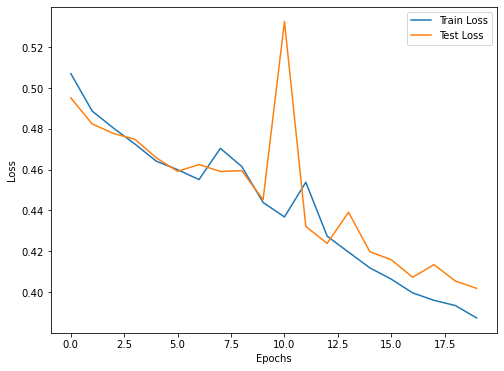

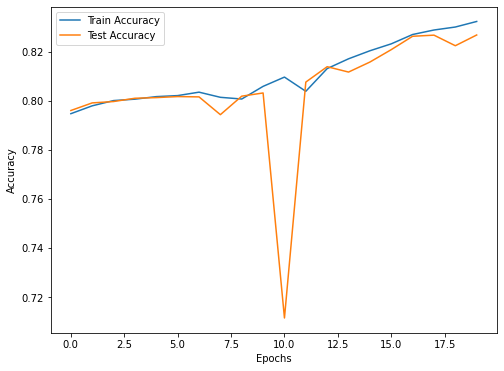

In [15]:
plots(history_1, 'loss')
plots(history_1, 'accuracy')

><font size = 4><font color = 'purple'>It seems to keep improving - will increase epochs.</font></font>

## Model 2 - epochs 50

In [16]:
# instantiate

model_2 = Sequential()

# add layers

model_2.add(Conv1D(filters = 128, kernel_size = 5, activation='relu', input_shape = (256, 1)))
model_2.add(Dropout(0.2))
model_2.add(Conv1D(filters = 64, kernel_size = 5, activation = 'relu'))
model_2.add(MaxPooling1D(pool_size = 4))
model_2.add(LSTM(100))
model_2.add(Dense(1, activation = 'sigmoid'))

# compile

model_2.compile(loss = 'bce', optimizer = 'adam', metrics = ['accuracy'])

# check model summary

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 252, 128)          768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 252, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 248, 64)           41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 107,893
Trainable params: 107,893
Non-trainable params: 0
________________________________________________

In [17]:
# fit

history_2 = model_2.fit(train, y_train,
                        batch_size = 128,
                        epochs = 50,
                        validation_data = (test, y_test))

Epoch 1/50
559/559 [==============================] - 90s 161ms/step - loss: 0.5115 - accuracy: 0.7938 - val_loss: 0.5069 - val_accuracy: 0.7947
Epoch 2/50
559/559 [==============================] - 101s 180ms/step - loss: 0.5002 - accuracy: 0.7959 - val_loss: 0.4938 - val_accuracy: 0.7964
Epoch 3/50
559/559 [==============================] - 104s 186ms/step - loss: 0.4874 - accuracy: 0.7982 - val_loss: 0.4912 - val_accuracy: 0.7961
Epoch 4/50
559/559 [==============================] - 108s 193ms/step - loss: 0.4817 - accuracy: 0.7995 - val_loss: 0.4818 - val_accuracy: 0.7993
Epoch 5/50
559/559 [==============================] - 107s 191ms/step - loss: 0.4793 - accuracy: 0.7999 - val_loss: 0.4811 - val_accuracy: 0.7992
Epoch 6/50
559/559 [==============================] - 109s 195ms/step - loss: 0.4777 - accuracy: 0.8004 - val_loss: 0.4797 - val_accuracy: 0.8004
Epoch 7/50
559/559 [==============================] - 110s 196ms/step - loss: 0.4758 - accuracy: 0.8005 - val_loss: 0.4797 - 

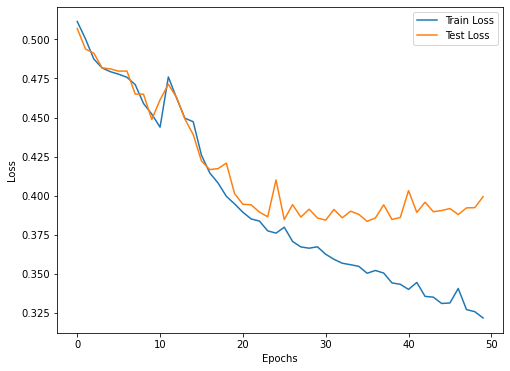

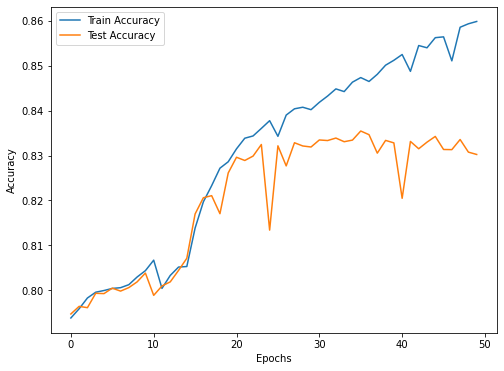

In [18]:
plots(history_2, 'loss')
plots(history_2, 'accuracy')

## Model 3 - Dropout 0.5, LSTM 10, no MaxPooling, batch size 256, with 25 epochs

In [19]:
# instantiate

model_3 = Sequential()

# add layers

model_3.add(Conv1D(filters = 128, kernel_size = 5, activation ='relu', input_shape = (256, 1)))
model_3.add(Dropout(0.5))
model_3.add(Conv1D(filters = 64, kernel_size = 5, activation = 'relu'))
#model_3.add(MaxPooling1D(pool_size = 4))
model_3.add(LSTM(10))
model_3.add(Dense(1, activation = 'sigmoid'))

# compile

model_3.compile(loss = 'bce', optimizer = 'adam', metrics = ['accuracy'])

# check model summary

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 252, 128)          768       
_________________________________________________________________
dropout_2 (Dropout)          (None, 252, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 248, 64)           41024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                3000      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 44,803
Trainable params: 44,803
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fit

history_3 = model_3.fit(train, y_train,
                        batch_size = 256,
                        epochs = 25,
                        validation_data = (test, y_test))

Epoch 1/25
280/280 [==============================] - 74s 264ms/step - loss: 0.5134 - accuracy: 0.7930 - val_loss: 0.5045 - val_accuracy: 0.7947
Epoch 2/25
280/280 [==============================] - 87s 310ms/step - loss: 0.5039 - accuracy: 0.7947 - val_loss: 0.5035 - val_accuracy: 0.7947
Epoch 3/25
280/280 [==============================] - 87s 311ms/step - loss: 0.5031 - accuracy: 0.7947 - val_loss: 0.5024 - val_accuracy: 0.7947
Epoch 4/25
280/280 [==============================] - 90s 321ms/step - loss: 0.5016 - accuracy: 0.7947 - val_loss: 0.5018 - val_accuracy: 0.7947
Epoch 5/25
280/280 [==============================] - 95s 340ms/step - loss: 0.5000 - accuracy: 0.7947 - val_loss: 0.4995 - val_accuracy: 0.7947
Epoch 6/25
280/280 [==============================] - 101s 362ms/step - loss: 0.4981 - accuracy: 0.7947 - val_loss: 0.4984 - val_accuracy: 0.7947
Epoch 7/25
280/280 [==============================] - 103s 369ms/step - loss: 0.4968 - accuracy: 0.7947 - val_loss: 0.4978 - val_

>No improvement. Adjust the first model further.

## Try GridSearch

In [24]:
# create a function skeleton for tuning

def model_func(layer_one_filters = 128, layer_one_kernel = 5,\
               layer_one_dropout = 0.5,\
               layer_two_filters = 32, layer_two_kernel = 5,\
               layer_two_dropout = 0.5,\
               maxpooling = 4,\
               lstm_unit = 10):
    
    # instantiate the model
    model = Sequential()
    
    # add layers
    model.add(Conv1D(filters = layer_one_filters, kernel_size = layer_one_kernel, activation ='relu', input_shape = (256, 1)))
    model.add(Dropout(layer_one_dropout))
    model.add(Conv1D(filters = layer_two_filters, kernel_size = layer_two_kernel, activation = 'relu'))
    model.add(Dropout(layer_two_dropout))
    model.add(MaxPooling1D(pool_size = maxpooling))
    model.add(LSTM(lstm_unit))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # compile
    model.compile(loss = 'bce', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

# build the model

nn = KerasClassifier(build_fn = model_func, epochs = 10, batch_size = 512, verbose = 0)

In [29]:
# params grid

params = {
    'epochs':[25, 50],
    'batch_size': [128, 256, 512],
    'lstm_unit': [10, 100, 150],
    'maxpooling': [4, 8, 12],
    'layer_one_filters': [16, 32],
    'layer_two_filters': [16, 32],
    'layer_one_kernel': [5, 10],
    'layer_two_kernel': [5, 10],
    'layer_one_dropout': [0.25, 0.5],
    'layer_two_dropout': [0.25, 0.5]
}

# instantiate gridsearch

gs = GridSearchCV(estimator = nn, param_grid = params, cv = 3)

In [ ]:
%%time

# fit

gs.fit(train, y_train)

print(f'Best score: {gs.best_score_}')
print(f'Best parameters: {gs.best_params_}')